<a href="https://colab.research.google.com/github/hariskhan-hk/Tumor_Classification/blob/main/Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tumor Classification

## I. Import Required Dependecies

In [ ]:
import os
import glob
from IPython.display import Image as IPImage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image           # Pillow - for image processing tasks

# TensorFlow - for deep learning operations and model management
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

# Keras - for building and training neural network models
from keras.layers import Flatten, Dense, Activation, Dropout
from keras import models, optimizers
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import DenseNet121
from keras.applications.densenet import DenseNet121, preprocess_input

# scikit-learn - for data splitting and model evaluation utilities
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## II. Read Dataset

### Path to the directory containing the images

In [ ]:
dataset = '/content/drive/MyDrive/Dataset_BUSI_with_GT'

pd.DataFrame(
    os.listdir(dataset),
    columns=['Classes']
)

,Classes
0,normal
1,malignant
2,benign


### Directory Paths Containing DataSet

In [ ]:
# Get a list of the file paths in the 'dataset' directory
train_files = [i for i in glob.glob(dataset + "/*/*")]

# Randomly shuffle the list of file paths
np.random.shuffle(train_files)

# Extract labels from the directory names of each file path
labels = [os.path.dirname(i).split("/")[-1] for i in train_files]

# Combine file paths & its corresponding labels into a list of tuples
data = zip(train_files, labels)

# Create a Pandas DataFrame with 2 columns. "Path" column contains file paths, & "Label" column contains corresponding labels
training_data = pd.DataFrame(data, columns=["Path", "Label"])

# Display the contents of the DataFrame
training_data

,Path,Label
0,/content/drive/MyDrive/Dataset_BUSI_with_GT/be...,benign
1,/content/drive/MyDrive/Dataset_BUSI_with_GT/be...,benign
2,/content/drive/MyDrive/Dataset_BUSI_with_GT/no...,normal
3,/content/drive/MyDrive/Dataset_BUSI_with_GT/no...,normal
4,/content/drive/MyDrive/Dataset_BUSI_with_GT/be...,benign
...,...,...
1573,/content/drive/MyDrive/Dataset_BUSI_with_GT/be...,benign
1574,/content/drive/MyDrive/Dataset_BUSI_with_GT/no...,normal
1575,/content/drive/MyDrive/Dataset_BUSI_with_GT/no...,normal
1576,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,malignant


## III. Data Visualization

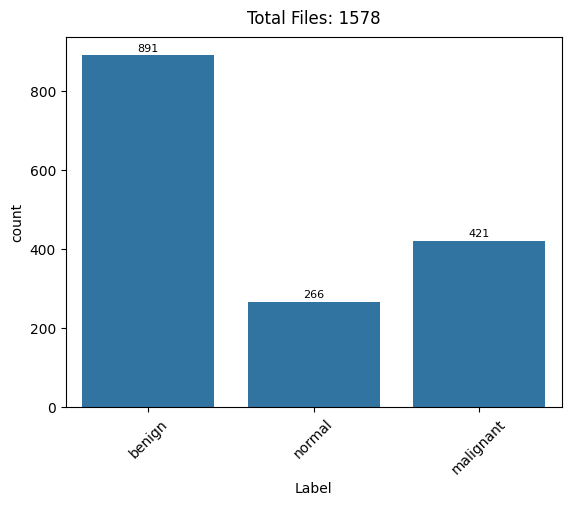

In [ ]:
# Create a countplot() using Seaborn, where x-axis represents the "Label" column of the training_data DataFrame
ax = sns.countplot(x=training_data["Label"])

# Display count inside each bar as integers
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add a title with the total count of files
plt.title(f'Total Files: {len(training_data)}', pad=10)

# Show the plot
plt.show()

## IV. Collect Data Paths & Labels from Directory Structure

In [ ]:
data_paths = []
labels = []

main_dirs = os.listdir(dataset)
for folder_name in main_dirs:
    folder_path = os.path.join(dataset, folder_name)
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data_paths.append(file_path)
        labels.append(folder_name)

## V. Data Preprocessing

In [ ]:
# Set the batch size for training
batch_size = 16

# Define the target image size for preprocessing
image_size = (256, 256)

# Specify the number of color channels in the images (3 for RGB)
num_channels = 3

# Create the image shape tuple based on the specified size and channels
image_shape = (image_size[0], image_size[1], num_channels)

# Create a Pandas Series containing file paths with the name 'Path'
data_dirs = pd.Series(data_paths, name='Path')

# Create a Pandas Series containing corresponding labels with the name 'Label'
classes = pd.Series(labels, name='Label')

# Split the dataset into training and validation-test sets
train_df, val_test_df = train_test_split(
    training_data,
    train_size=0.8,
    shuffle=True,
    random_state=123
)

# Split the val_test_df set into validation and test sets
val_df, test_df = train_test_split(
    val_test_df,
    train_size=0.5,
    shuffle=True,
    random_state=123
)

# ImageDataGenerator configuration, normalize pixel values from 0-255 to 0-1.
datagen = ImageDataGenerator(
    rescale=1.0/255
)

# Convert the 'Label' column to string type
train_df['Label'] = train_df['Label'].astype(str)
val_df['Label'] = val_df['Label'].astype(str)

# Create generators for training and validation
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='Path',
    y_col='Label',
    target_size=image_size, # resize to image_size
    class_mode='categorical', # organize labels using categorical mode (for multi-class classification)
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size # use batches of size batch_size
)

valid_generator = datagen.flow_from_dataframe(
    val_df,
    x_col='Path',
    y_col='Label',
    target_size=image_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

Found 1262 validated image filenames belonging to 3 classes.
Found 158 validated image filenames belonging to 3 classes.


### Display Class Names

In [ ]:
# Get the class indices (mapping of the class names to numerical indices) from the training generator
class_indices = train_generator.class_indices
print(class_indices)

{'benign': 0, 'malignant': 1, 'normal': 2}


## VI. Build Model

In [ ]:
# Load the DenseNet-121 model with pre-trained ImageNet weights, excluding the top classification layer
base_model = DenseNet121(
    weights='/content/drive/MyDrive/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5',
    include_top=False,     # Excludes the final Dense layers used for ImageNet classification
    input_shape=(256, 256, 3)  # Specifies the input shape of the images
)

# Freeze all layers of the base DenseNet model to retain pre-trained features
for layer in base_model.layers:
    layer.trainable = False

# Create a new Sequential model
model = Sequential()

# Add the DenseNet base model as the feature extractor
model.add(base_model)

# Flatten the output feature maps to feed into fully connected layers
model.add(Flatten())

# Add fully connected layers to learn from extracted features
model.add(Dense(1024, activation='relu'))  # First dense layer with ReLU activation
model.add(Dense(1024, activation='relu'))  # Second dense layer
model.add(Dense(512, activation='relu'))   # Third dense layer

# Add another dense layer before the final output layer
model.add(Dense(128, activation='relu'))

# Final classification layer with softmax activation for 3 output classes
model.add(Dense(3, activation='softmax'))

# Display a summary of the model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │    67,109,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,787,843 (289.11 MB)

 Trainable params: 68,750,339 (262.26 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

### Create Model Checkpoint Callback to Save Best Model

In [20]:
# Define the path to save the best model checkpoint
checkpoint_path = "/content/working/model.keras"

# Create a ModelCheckpoint callback
# This callback saves the model when validation accuracy improves
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,     # Save only the best model
    mode='max',              # Save based on the maximum validation accuracy
    verbose=1                # Display progress information
)

## VII. Compile Model

In [21]:
# Compile the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

## VIII. Train Model

In [22]:
# Train the model using the fit() method
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6230 - loss: 4.2513
Epoch 1: val_accuracy improved from -inf to 0.87500, saving model to /content/working/model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 438s 5s/step - accuracy: 0.6243 - loss: 4.2221 - val_accuracy: 0.8750 - val_loss: 0.3069
Epoch 2/20
 1/78 ━━━━━━━━━━━━━━━━━━━━ 5:11 4s/step - accuracy: 0.8750 - loss: 0.2447

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.87500
78/78 ━━━━━━━━━━━━━━━━━━━━ 41s 475ms/step - accuracy: 0.8750 - loss: 0.2447 - val_accuracy: 0.8611 - val_loss: 0.3618
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8785 - loss: 0.3062
Epoch 3: val_accuracy did not improve from 0.87500
78/78 ━━━━━━━━━━━━━━━━━━━━ 438s 6s/step - accuracy: 0.8784 - loss: 0.3062 - val_accuracy: 0.8611 - val_loss: 0.6134
Epoch 4/20
 1/78 ━━━━━━━━━━━━━━━━━━━━ 5:50 5s/step - accuracy: 0.9375 - loss: 0.3056
Epoch 4: val_accuracy did not improve from 0.87500
78/78 ━━━━━━━━━━━━━━━━━━━━ 39s 442ms/step - accuracy: 0.9375 - loss: 0.3056 - val_accuracy: 0.8542 - val_loss: 0.6389
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9205 - loss: 0.2320
Epoch 5: val_accuracy did not improve from 0.87500
78/78 ━━━━━━━━━━━━━━━━━━━━ 413s 5s/step - accuracy: 0.9204 - loss: 0.2324 - val_accuracy: 0.8333 - val_loss: 0.4716
Epoch 6/20
 1/78 ━━━━━━━━━━━━━━━━━━━━ 4:56 4s/step - accuracy: 0.9375 - loss

In [ ]:
from google.colab import files

# Path to the file you want to download
file_path = '/content/working/model.keras'

# Download the file
files.download(file_path)